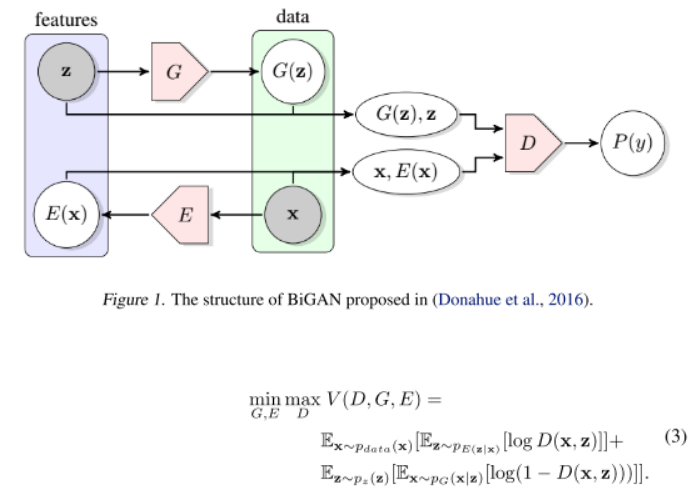

위 그림에 보이는 BiGAN 에서 눈에 띄는 것은 바로 Geneator G와 Discriminator D 이외에도 G의 역함수 구실을 하는 E 네트워크가 존재한다는 점입니다. 이것은 이미지 를 latent space로 인코딩하는 Encoder입니다. 그래서 Discriminator는 와 를 비교하는 게 아니라 와 를 비교하는 형태로 구성됩니다.

여기서 중요한 것은 이제 우리는 x->z 로의 Encoder를 얻었다는 점입니다.

그래서 AnoGAN의 아이디어와 BiGAN의 Encoder 개념을 결합하여 GAN을 이용한 Anomaly Detection의 기본 아이디어를 완성시킨 것으로 평가받는 GANomaly 모델이 나오게 됩니다

## 28-3. GANomaly

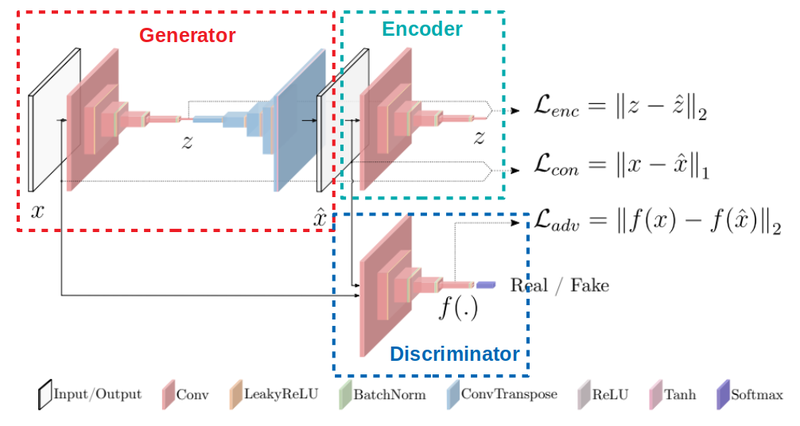

GANomaly의 기본 아이디어는 이전의 AnoGAN과 BiGAN Encoder에서 가져온 것입니다. 그러나 이를 잘 결합하여 위 그림의 위쪽줄에 보이는 Encoder-Decoder-Encoder 구조의 네트워크로 다시 묶어냈다는 점에 주목할 만 합니다. 학습데이터로 Normal 데이터만 사용한다는 점은 AnoGAN의 구성과 동일합니다.

이 모델의 Generator는 일반적인 GAN과 달리 Encoder-Decoder 구조를 가지고 있으며, 입력값이 latent variable 가 아니라 이미지 입니다. 그리고 Encoder가 Generator의 decoder 뒤에 연결되어 있습니다.

위 모델 구조를 가지고 3가지 Loss를 최소화하는 형태로 학습이 진행됩니다.

Adversarial Loss/
 Contextual Loss/
 Encoder Loss

여기서 Adversarial Loss 는 AnoGAN의 feature matching의 아이디어를 그대로 가져온 것입니다. 는 discriminator의 중간 레이어입니다. 즉 Discriminator가 Normal 데이터에 최적화되길 바라는 것입니다. Contextual Loss는 AnoGAN의 Residual Loss와 같은 개념입니다. Generator가 Normal 데이터를 잘 복원해 내길 바라는 것입니다. 마지막으로 Encoder Loss는 Genrator의 Encoder가 만들어 낸 latent variable과 별도 Encoder가 만들어 낸 latent variable이 거의 근사하길, 그래서 Encoder가 AnoGAN에서 하고 싶었던 Generator의 latent space를 잘 모사하길 바라는 것입니다.

그래서 전체적인 Loss는 아래와 같습니다.

여기서 , ,  는 weighting parameter로 함께 학습됩니다.

GANomaly는 AnoGAN에 비해 훨씬 간결한 학습 구조와 뛰어난 성능으로 이후 주목받게 됩니다.
그러나, 좀더 개선할 여지가 보입니다. 예를 들어 Contextual Loss의 경우 이미지  x를 잘 복원하기 위해서는 Generator가 일반적인 Encoder-Decoder 구조를 가지는 것보다는 UNet처럼 만들면 더 잘 복원하지 않을까요? 이런 아이디어들이 적용되어 보완된 새로운 모델이 다시 등장하게 됩니다.

## 28-4. Skip-GANomaly
Skip-GANomaly

GANomaly의 저자가 발표한 후속 논문입니다.
Skip-GANomaly 모델은 GANomaly 에서 Generator만 UNet 구조로 바꾼 것으로 생각할 수 있습니다. 하지만 그것만 달라진 것은 아닙니다. 아래 그림을 보면 Generator 뒤에 달려 있던 Encoder가 어디론가 사라져 버렸습니다. latent variable 분포를 고려했던 AnoGAN 방식의 접근이 불필요하게 된 것입니다.

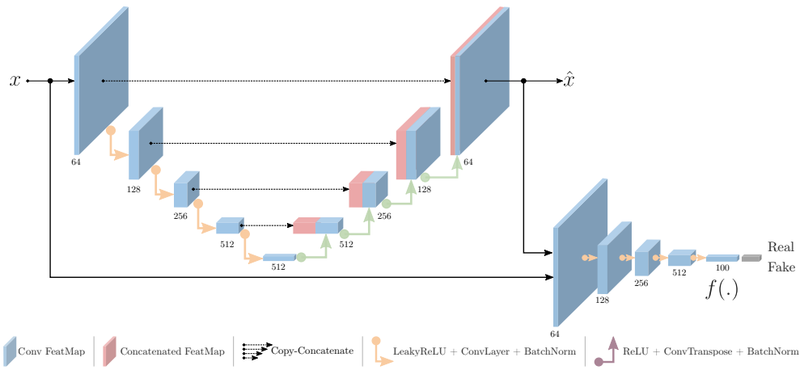

## 28-5. 데이터셋 구성(Fashion-MNIST)

지금부터는 Skip-GANomaly 모델을 실제로 구현하는 과정을 진행하려고 합니다. 이런 이상감지 모델을 학습할 때 쉽게 사용하는 데이터 구성은 MNIST 같이 잘 알려진 데이터셋에서 특정 클래스를 이상 데이터로 활용하는 방식입니다. 예를 들어 0으로 라벨링된 모든 이미지를 훈련 데이터에서 제거하고 1~9로만 학습을 시킨 후 테스트 데이터를 0을 포함한(이상 데이터를 포함한) 형태로 구성하여 이상감지 성능을 평가하는 방식입니다.

오늘 우리는 Fashion MNIST를 활용해 볼 것입니다. Fashion MNIST에서 8번 라벨이 가방(Bag)입니다. 그래서 이번에는 가방을 제거하고 의복과 신발류로만 구성된 Fashion MNIST를 정상 데이터로 삼아볼 생각입니다. 말하자면, 우리의 모델은 가방이라는 패션 아이템을 보도듣도 못하였으며, 가방이라는 패션이라는 것은 매우 특이한 상황이라고 가정하는 것입니다^^

In [16]:
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

### 이상감지 데이터셋 구축

위에서 언급한 대로 학습/테스트 데이터셋을 구축해 보겠습니다.

(주의) Fashion-MNIST는 1채널 grayscale 데이터셋입니다. 그냥은 Convolution 연산이 되지 않으므로 채널방향 차원이 하나 늘어나도록 reshape하는 과정이 필요합니다.

In [23]:

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

from PIL import Image


# (train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

# # 1channel data reshape
# train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
# test_data = test_data.reshape(test_data.shape[0], 28, 28, 1).astype('float32')



# # Fashion MNIST padding to 32 X 32

# train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
# test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')   

# train_data_32[:, 2:30, 2:30] = train_data
# test_data_32[:, 2:30, 2:30] = test_data

# # 1channel data reshape
# train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
# test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')

train_labels

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


잠깐 Fashion-MNIST 데이터가 어떻게 생겼는지 확인해 볼까요?

UNet 구조의 활용을 위해서 기존의 28 X 28 사이즈의 Fashion-MNIST 데이터 이미지를 32 X 32 로 패딩처리해 줄 필요가 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

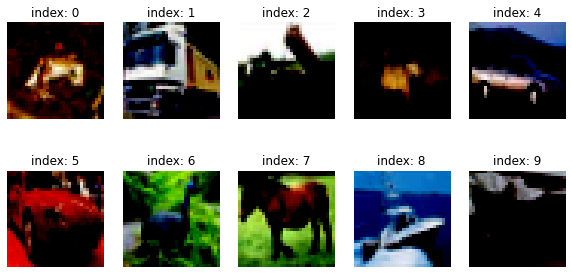

In [24]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i].reshape(32, 32,3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

개구리인 6번 라벨(Bag) 데이터를 제외하도록 하겠습니다.

In [25]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # Bag:8
            new_t_labels.append([0])  # Bag을 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [26]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [27]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [28]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [29]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [30]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


데이터셋이 정확하게 구성되었는지 좀더 검증해 보겠습니다.

In [31]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


### 이제 데이터셋을 구성하고 label을 검증해 보겠습니다.

훈련 데이터셋에는 라벨이 1인 데이터만 존재하고, 테스트 데이터에는 0과 1이 섞여 있어야 합니다.



In [32]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [33]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [34]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


## 28-6. 모델과 Loss함수 구성

### Generator
Generator는 그동안 자주 다루었을 UNet 구조를 따릅니다.



In [35]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [36]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [37]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2

        self.center = layers.Conv2D(512, 3, strides=2, padding='same', use_bias=False) # 1

        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16

        self.output_layer = layers.Conv2DTranspose(3, 1, strides=2, padding='same',
                                                   use_bias=False, activation='tanh', # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))

    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)

        center = self.center(en_4)

        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)

        outputs = self.output_layer(de_1)

        return outputs

### Discriminator

Discriminator도 Generator처럼 Conv_block을 활용하며, 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴합니다

In [38]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.dense_output = layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.dense_output(center)
        
        return outputs, center

### 전체 모델 구성

Generator와 Discriminator을 합쳐 전체 모델을 구성해 봅시다.

In [39]:
generator = Generator()
discriminator = Discriminator()

### Loss 함수

GAN 모델의 핵심은 Loss 함수의 구성방법에 달려 있다고 해도 과언이 아닙니다. Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행됩니다.



In [40]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [41]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

아래 Generator Loss에는 이전 스텝에서 설명했던 Skip-GANomaly의 주요 loss 함수들이 포함되어 있음을 주목해 주세요.

In [42]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [43]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## 28-7. 모델 학습과 평가

### Model Train

이제 본격적으로 모델을 학습해 보겠습니다. 총 25Epoch 대략 1시간 정도 소요될 수 있습니다.

In [44]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [45]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Steps : 100, 	 T

Steps : 7500, 	 Total Gen Loss : 27.56313705444336, 	 Total Dis Loss : 0.012434772215783596
Steps : 7600, 	 Total Gen Loss : 25.612533569335938, 	 Total Dis Loss : 0.0011319632176309824
Steps : 7700, 	 Total Gen Loss : 23.275266647338867, 	 Total Dis Loss : 0.0028076518792659044
Steps : 7800, 	 Total Gen Loss : 25.975616455078125, 	 Total Dis Loss : 0.007896949537098408
Steps : 7900, 	 Total Gen Loss : 22.238954544067383, 	 Total Dis Loss : 0.011092188768088818
Steps : 8000, 	 Total Gen Loss : 21.57172966003418, 	 Total Dis Loss : 0.010170212015509605
Steps : 8100, 	 Total Gen Loss : 21.035682678222656, 	 Total Dis Loss : 0.0033838897943496704
Steps : 8200, 	 Total Gen Loss : 23.465761184692383, 	 Total Dis Loss : 0.012181572616100311
Steps : 8300, 	 Total Gen Loss : 22.755266189575195, 	 Total Dis Loss : 0.001537573174573481
Steps : 8400, 	 Total Gen Loss : 20.454923629760742, 	 Total Dis Loss : 0.002169060753658414
Steps : 8500, 	 Total Gen Loss : 25.190351486206055, 	 Total Dis Loss

Steps : 16200, 	 Total Gen Loss : 23.523508071899414, 	 Total Dis Loss : 0.0005450506578199565
Steps : 16300, 	 Total Gen Loss : 20.8551025390625, 	 Total Dis Loss : 0.004259026609361172
Steps : 16400, 	 Total Gen Loss : 23.159990310668945, 	 Total Dis Loss : 0.0009645695681683719
Steps : 16500, 	 Total Gen Loss : 21.62349510192871, 	 Total Dis Loss : 0.00106982106808573
Steps : 16600, 	 Total Gen Loss : 23.127166748046875, 	 Total Dis Loss : 0.010776937007904053
Steps : 16700, 	 Total Gen Loss : 29.08217430114746, 	 Total Dis Loss : 0.0035861029755324125
Steps : 16800, 	 Total Gen Loss : 24.402725219726562, 	 Total Dis Loss : 0.0012279468355700374
Time for epoch 3 is 403.48661947250366 sec
Steps : 16900, 	 Total Gen Loss : 22.678861618041992, 	 Total Dis Loss : 0.0011908009182661772
Steps : 17000, 	 Total Gen Loss : 22.79659652709961, 	 Total Dis Loss : 0.0007474504527635872
Steps : 17100, 	 Total Gen Loss : 24.599206924438477, 	 Total Dis Loss : 0.0010716565884649754
Steps : 17200, 	

Steps : 24900, 	 Total Gen Loss : 26.30471420288086, 	 Total Dis Loss : 0.0002080475096590817
Steps : 25000, 	 Total Gen Loss : 27.399127960205078, 	 Total Dis Loss : 0.00045823794789612293
Steps : 25100, 	 Total Gen Loss : 24.44939613342285, 	 Total Dis Loss : 0.000547341420315206
Steps : 25200, 	 Total Gen Loss : 26.184459686279297, 	 Total Dis Loss : 0.0020760728511959314
Steps : 25300, 	 Total Gen Loss : 23.452556610107422, 	 Total Dis Loss : 0.0019510275451466441
Steps : 25400, 	 Total Gen Loss : 24.350732803344727, 	 Total Dis Loss : 0.0003581352939363569
Steps : 25500, 	 Total Gen Loss : 23.38318634033203, 	 Total Dis Loss : 0.0007288191118277609
Steps : 25600, 	 Total Gen Loss : 24.200841903686523, 	 Total Dis Loss : 0.0005863739061169326
Steps : 25700, 	 Total Gen Loss : 24.58700942993164, 	 Total Dis Loss : 0.0001858937175711617
Steps : 25800, 	 Total Gen Loss : 24.32331657409668, 	 Total Dis Loss : 0.0002788968849927187
Steps : 25900, 	 Total Gen Loss : 28.413305282592773, 	

### Model Evaluation

학습 도중 저장된 Checkpoint를 아래와 같이 활용할 수 있습니다.

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [48]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [49]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


아래와 같이 테스트 결과를 원래 라벨에 따라 anomaly 데이터와 normal 데이터로 나누어 따로 분석해 봅니다.

라벨에 따라 anomaly score의 분포가 다르게 나타나는지를 검증해 보겠습니다.

In [50]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


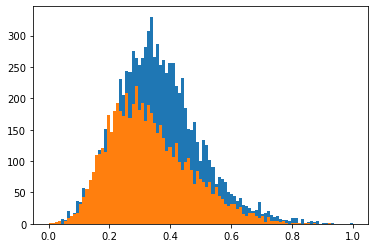

In [51]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.36093223 0.33165008
0.13541526 0.133822


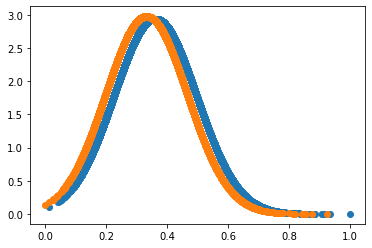

In [52]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

GAN을 이용하면 Anomaly 데이터가 부족한 상황에서도 Unsupervised 방식으로 Anomaly Detection 모델 구현했으며, Unet을 이용한 skip-Ganomaly 모델을 사용해 anormal데이터를 시각화할수있었다.

데이터들의 밀도를 이용하는 함수가 될 것입니다.(Density estimation) 

이 p 함수는 이 데이터가 정상적인 데이터일 가능성(probability)을 의미합니다. 이 함수를 사용해서 데이터를 확인을 한 결과 값이 어떤 특정한 값(ε)보다 작을 경우에는 이 데이터는 비정상적이다(flag anomaly) 라고 판단할 수 있습니다. 물론 그 반대의 경우에는 정상적인 데이터가 되겠지요

- 사기 탐지 : 웹사이트의 많은 사용자들 중에서 특별하게 이상한 행동을 취하는 사용자를 판별하여 문제 있는 사용자를 파악합니다.
                    이때 다양한 features들을 만들 수 있습니다.(로그인 여부와 위치정보나 행동 패턴이 유사한지, 접속시간등)
                    만약 이상하다고 판단이 되면 해당 사용자를 block 처리 하여 다른 문제가 발생하는 것을 방지할 수 있겠습니다.

- 생산제품 QA : 제조한 물건에 이상 또는 불량 여부를 확인하는데 활용될 수 있습니다. 위의 예제와 비슷하지요

출처: https://daeson.tistory.com/216 [대소니]